In [3]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [4]:
spark

In [5]:
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
import re
# import tensorflow as tf
# import cv2

I will use the functionality of Image Datasource of spark to collect and process images in bytes, and then start processing the images for the neural network

In [6]:
images_folders = ['/CA1/Images/Ireland/','/CA1/Images/Honduran/']

In [7]:
images_rdd = spark.sparkContext.binaryFiles(','.join(images_folders))
# images_rdd = spark.sparkContext.binaryFiles('hdfs://172.24.144.178:9000/CA1/Images/Ireland/Ireland_001.jpeg')

In [8]:
images_rdd

org.apache.spark.api.java.JavaPairRDD@303e7f0f

In [9]:
def extract_data(data):
    file_path, image_data = data
#     image = Image.open(BytesIO(image_data))
#     image_array = np.array(image)
    
    file_name = file_path.split('/')[-1]
    file_name_without_ext = file_name.split(".")[0]
    label,name = file_name_without_ext.split('_')[0], file_name_without_ext.split('_')[1]
    
    return name, label, image_data

In [10]:
imageDf = images_rdd.map(lambda x: extract_data(x)).toDF(["Name","Label","Data"])

In [11]:
pandasImagesDF = imageDf.toPandas()

In [12]:
IMG_SHAPE=225

In [13]:
def processImage(data, target_size=(IMG_SHAPE,IMG_SHAPE)):
    imgbytes = BytesIO(data)
    image = Image.open(imgbytes)
    resized_img = image.resize(target_size, Image.ANTIALIAS)
    with BytesIO() as output:
        resized_img.save(output, format="PNG")
        new_image = Image.open(output)

        array = np.asarray(new_image).reshape([target_size[0],target_size[1],3])
        return array

In [14]:
pandasImagesDF["Data"] = pandasImagesDF["Data"].apply(lambda x: processImage(x))

In [15]:
# pandasImagesDF

In [16]:
pandasImagesDF = pandasImagesDF.sort_values(by=["Name"])

In [17]:
pandasImagesDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    180 non-null    object
 1   Label   180 non-null    object
 2   Data    180 non-null    object
dtypes: object(3)
memory usage: 5.6+ KB


In [18]:
NCATEGORIES = len(pandasImagesDF["Label"].unique())

Importing from Keras functionality necessary to implement CNN

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input
from tensorflow.keras import utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

2024-03-22 00:21:28.950052: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 00:21:29.050486: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 00:21:29.413241: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 00:21:30.427969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Now we are to split the data using train_test_split function to use Kfold and improve the perfomance of the model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(pandasImagesDF["Data"],pandasImagesDF["Label"],test_size=0.3, random_state=42)

In [21]:
encoder = OneHotEncoder(sparse_output=False)
y_train = np.array(y_train).reshape(-1, 1)
y_train = encoder.fit_transform(y_train)

y_test = np.array(y_test).reshape(-1,1)
y_test = encoder.fit_transform(y_test)

In [22]:
X_train = np.stack(X_train)
X_test = np.stack(X_test)

In [23]:
X_train.shape

(126, 225, 225, 3)

In [24]:
X_train = np.reshape(X_train,(X_train.shape[0],IMG_SHAPE,IMG_SHAPE,3)).astype(np.float32)
X_test = np.reshape(X_test,(X_test.shape[0],IMG_SHAPE,IMG_SHAPE,3)).astype(np.float32)

Because the pixels are from 0 to 255, We have to normalize the pixels

In [25]:
X_train/=255
X_test/=255

In [26]:
X_train.shape,X_test.shape

((126, 225, 225, 3), (54, 225, 225, 3))

In [27]:
y_train.shape, y_test.shape

((126, 2), (54, 2))

In [28]:
model = Sequential()
model.add(Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)))  # 225x225 RGB images
model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),padding="valid", activation="relu"))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D(3))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPool2D(2))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPool2D(2))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPool2D(2))

model.add(Flatten())


model.add(Dense(128, activation="relu"))
model.add(Dense(NCATEGORIES,activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

2024-03-22 00:21:42.156738: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 00:21:42.157228: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [29]:
model.fit(X_train, y_train, batch_size=50, epochs=25, verbose=1, validation_data=(X_test, y_test))

Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4383 - loss: 0.6974 - val_accuracy: 0.4259 - val_loss: 0.6931
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5369 - loss: 0.6933 - val_accuracy: 0.4259 - val_loss: 0.6905
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5434 - loss: 0.6916 - val_accuracy: 0.4259 - val_loss: 0.6851
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5459 - loss: 0.6876 - val_accuracy: 0.4259 - val_loss: 0.6765
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5434 - loss: 0.6830 - val_accuracy: 0.4259 - val_loss: 0.6722
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5409 - loss: 0.6778 - val_accuracy: 0.4259 - val_loss: 0.6752
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5866 - loss: 0.6728 - val_accuracy: 0.5556 - val_loss: 0.6873
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6704 - loss: 0.6573 - val_accuracy: 0.5556 - val_loss: 0.7055
Epoch 9/25
3/3 ━

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 221, 221, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,256 (1.93 MB)

 Trainable params: 168,418 (657.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 336,838 (1.28 MB)

In [31]:
pred = model.predict(X_test[:25])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


In [32]:
def comparePredictions(predictionsValues, expectedValues):
    correct = 0
    for x in range(len(predictionsValues)):
        if predictionsValues[x] == expectedValues[x]:
            correct+=1
    
    print(f'Correct predictions {correct}/{len(predictionsValues)}. Percent {correct/len(predictionsValues)}')

In [33]:
comparePredictions(np.argmax(pred, axis=1),np.argmax(y_test[:25], axis=1))

Correct predictions 8/25. Percent 0.32


### Trying Data Augmentation 

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
X_train, X_test, y_train, y_test = train_test_split(pandasImagesDF["Data"],pandasImagesDF["Label"],test_size=0.3, random_state=42)

In [36]:
encoder = OneHotEncoder(sparse_output=False)
y_train = np.array(y_train).reshape(-1, 1)
y_train = encoder.fit_transform(y_train)

y_test = np.array(y_test).reshape(-1,1)
y_test = encoder.fit_transform(y_test)

X_train = np.stack(X_train)
X_train = np.reshape(X_train,(X_train.shape[0],IMG_SHAPE,IMG_SHAPE,3)).astype(np.float32)
X_train/=255

X_test = np.stack(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],IMG_SHAPE,IMG_SHAPE,3)).astype(np.float32)
X_test/=255

In [37]:
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation between 0 and 20 degrees
    width_shift_range=0.1,  # Randomly shift the width by up to 10%
    height_shift_range=0.1,  # Randomly shift the height by up to 10%
    shear_range=0.2,  # Shear intensity (shear angle in counter-clockwise direction in radians)
    zoom_range=0.2,  # Randomly zoom in by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill mode for points outside the input boundaries
)

In [149]:
print("Shape of X_train:", X_train.shape)
print("Type of X_train:", type(X_train))
print("Shape of y_train:", y_train.shape)
print("Type of y_train:", type(y_train))

Shape of X_train: (126, 225, 225, 3)
Type of X_train: <class 'numpy.ndarray'>
Shape of y_train: (126,)
Type of y_train: <class 'pandas.core.series.Series'>


In [150]:
augmented_generator = datagen.flow(np.array(X_train), np.array(y_train), batch_size=32)

In [151]:
augmented_generator

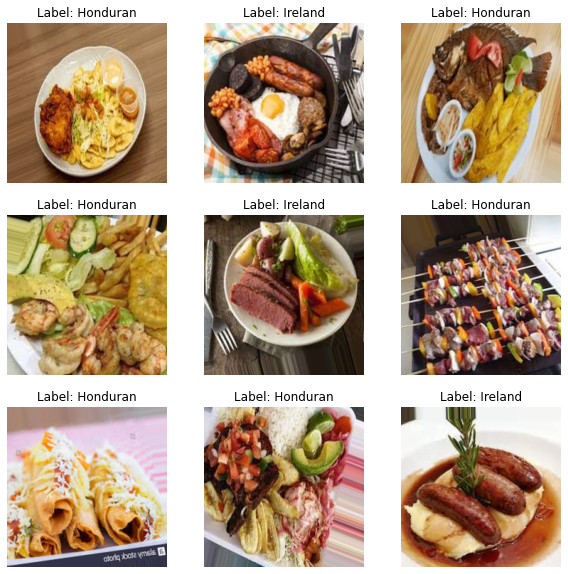

In [152]:
# Get a batch of augmented data
images, labels = next(augmented_generator)

# Visualize the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()

In [38]:
from tensorflow.keras.layers import RandomContrast, RandomBrightness, RandomRotation, RandomFlip

In [39]:
dataAugmented = Sequential()
dataAugmented.add(RandomContrast(0.7))
dataAugmented.add(RandomBrightness(0.7))
dataAugmented.add(RandomRotation(0.4))
dataAugmented.add(RandomFlip())


In [40]:
model = Sequential()
model.add(Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)))  # 225x225 RGB images
model.add(dataAugmented)
model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),padding="valid", activation="relu"))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D(3))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPool2D(2))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPool2D(2))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPool2D(2))

model.add(Flatten())


model.add(Dense(128, activation="relu"))
model.add(Dense(NCATEGORIES,activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

In [41]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((126, 225, 225, 3), (54, 225, 225, 3), (126, 2), (54, 2))

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_test, y_test))

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5231 - loss: 0.6949 - val_accuracy: 0.4259 - val_loss: 0.7020
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 995ms/step - accuracy: 0.5343 - loss: 0.6929 - val_accuracy: 0.4259 - val_loss: 0.7033
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5158 - loss: 0.6929 - val_accuracy: 0.4259 - val_loss: 0.7025
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5439 - loss: 0.6899 - val_accuracy: 0.4259 - val_loss: 0.7028
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5398 - loss: 0.6918 - val_accuracy: 0.4259 - val_loss: 0.7031
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5419 - loss: 0.6902 - val_accuracy: 0.4259 - val_loss: 0.7033
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5574 - loss: 0.6899 - val_accuracy: 0.4259 - val_loss: 0.7035
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5814 - loss: 0.6884 - val_accuracy: 0.4259 - val_loss: 0.7042
Epoch 9/30
4/

In [171]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 223, 223, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 221, 221, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 71, 71, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 69, 69, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,256 (1.93 MB)

 Trainable params: 168,418 (657.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 336,838 (1.28 MB)

In [43]:
pred = model.predict(X_test[:25])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


In [44]:
comparePredictions(np.argmax(pred, axis=1),np.argmax(y_test[:25], axis=1))

Correct predictions 11/25. Percent 0.44
